In [57]:
import numpy as np
import random
import os

# fix random seed
SEED = 42  

# Python built-in random
random.seed(SEED)

# NumPy random
np.random.seed(SEED) # scikit-learn sẽ tự dùng numpy seed ngầm bên trong)

# Đảm bảo các process con (nếu có) cũng dùng cùng seed
os.environ['PYTHONHASHSEED'] = str(SEED)


In [58]:
import joblib
import pandas as pd
import optuna

from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import TimeSeriesSplit

from src import data_preprocessing as dp
from src import pipeline as pl
from src import feature_engineering as fe
from src.model_evaluation import evaluate
from sklearn.model_selection import cross_val_score 

In [71]:
# 1. Load raw Data
print('step 1')
df = dp.load_data(r"data\raw data\Hanoi Daily 10 years.csv")


# 2. basic preprocessing for all data set
# đang để là có drop description 
print()
print('step 2')
df = dp.basic_preprocessing(df=df)
print("Shape:", df.shape)


# 3. chia train, val, test (tỉ lệ 70/15/15)
print()
print('step 3')

target_col = 'temp'
train_size = 0.7
val_size = 0.15
n = len(df)

train_df = df.iloc[:int(train_size*n)]
val_df = df.iloc[int(train_size*n):int((train_size+val_size)*n)]
test_df = df.iloc[int((train_size+val_size)*n):]

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

step 1
 Loaded data with shape: (3660, 33)

step 2
Dropped column: 'description'
Dropped column: 'severerisk'
Dropped column: 'icon'
Dropped column: 'stations'
Shape: (3660, 28)

step 3
Train: 2562, Val: 549, Test: 549


In [72]:
# 4. Fit và transform trên preprocessing pipeline
pipeline1 = pl.build_preprocessing_pipeline()

# fit trên train
pipeline1.fit(train_df)

# transform 
train_processed = pipeline1.transform(train_df)
val_processed = pipeline1.transform(val_df)
test_processed = pipeline1.transform(test_df)



c:\Users\Admin\Documents\ML\group1\src\data_preprocessing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=self.cols_to_drop_, errors='ignore', inplace=True)
c:\Users\Admin\Documents\ML\group1\src\data_preprocessing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=self.cols_to_drop_, errors='ignore', inplace=True)
c:\Users\Admin\Documents\ML\group1\src\data_preprocessing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [61]:
# Tạo feature engineering
column_lag = ['tempmax', 'tempmin', 'dew', 'humidity', 'precip',
    'precipprob', 'precipcover', 'windgust', 'windspeed',
    'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation']
train_feat = fe.feature_engineering(train_processed, column= column_lag)
val_feat = fe.feature_engineering(val_processed, column= column_lag)
test_feat = fe.feature_engineering(test_processed, column= column_lag)
print(train_feat.shape)


(2562, 114)


In [62]:
# Chia X, y riêng biệt
X_train, y_train = train_feat.drop(columns=[target_col]), train_df[target_col]
X_val, y_val = val_feat.drop(columns=[target_col]), val_df[target_col]
X_test, y_test = test_feat.drop(columns=[target_col]), test_df[target_col]

print(f"Train: {X_train.shape, y_train.shape}, Val: {X_val.shape, y_val.shape}, Test: {X_test.shape, y_test.shape}")

Train: ((2562, 113), (2562,)), Val: ((549, 113), (549,)), Test: ((549, 113), (549,))


In [73]:
# thử chỉ có preprocessing
X_train_base, y_train_base = train_processed.drop(columns=[target_col]), train_df[target_col]
X_val_base, y_val_base = val_processed.drop(columns=[target_col]), val_df[target_col]
X_test_base, y_test_base = test_processed.drop(columns=[target_col]), test_df[target_col]

X_train_base = X_train.drop(['sunrise', 'sunset'], axis= 1)
X_val_base = X_val.drop(['sunrise', 'sunset'], axis= 1)
X_test_base= X_test.drop(['sunrise', 'sunset'], axis= 1)

print(f"Train: {X_train_base.shape, y_train.shape}, Val: {X_val_base.shape, y_val.shape}, Test: {X_test_base.shape, y_test.shape}")

Train: ((2562, 111), (2562,)), Val: ((549, 111), (549,)), Test: ((549, 111), (549,))


In [ ]:
X_train_base = X_train.drop(['', 'tempmax'], axis= 1)
X_val_base = X_val.drop(['sunrise', 'sunset'], axis= 1)
X_test_base= X_test.drop(['sunrise', 'sunset'], axis= 1)

### Random Forest

In [64]:
# 1. fit 
model1 = RandomForestRegressor(n_estimators = 100, min_samples_split=2, min_samples_leaf=1,min_impurity_decrease=0, 
                               max_depth= 7, max_features= None, bootstrap= True, oob_score= False, 
                               max_leaf_nodes= None, max_samples= None
                               )
model1.fit(X_train, y_train) # sau này đầy đủ feature engineering thì thay X đầy đủ feature vào

# 2. predict
y_pred_val = model1.predict(X_val) 
y_pred_test = model1.predict(X_test)

In [69]:
# Lấy feature importance
importances = model1.feature_importances_

# Tạo DataFrame hiển thị
feat_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importance)

                Feature    Importance
35  pressure_temp_index  5.746446e-01
0               tempmax  2.176490e-01
1               tempmin  2.024941e-01
61  tempmax_roll_mean_3  7.095637e-04
65  tempmin_roll_mean_3  6.164205e-04
..                  ...           ...
45        season_spring  1.667402e-07
41   conditions_encoded  1.228406e-07
53     precipprob_lag_1  1.025084e-07
43  wind_category_South  0.000000e+00
40                foggy  0.000000e+00

[113 rows x 2 columns]


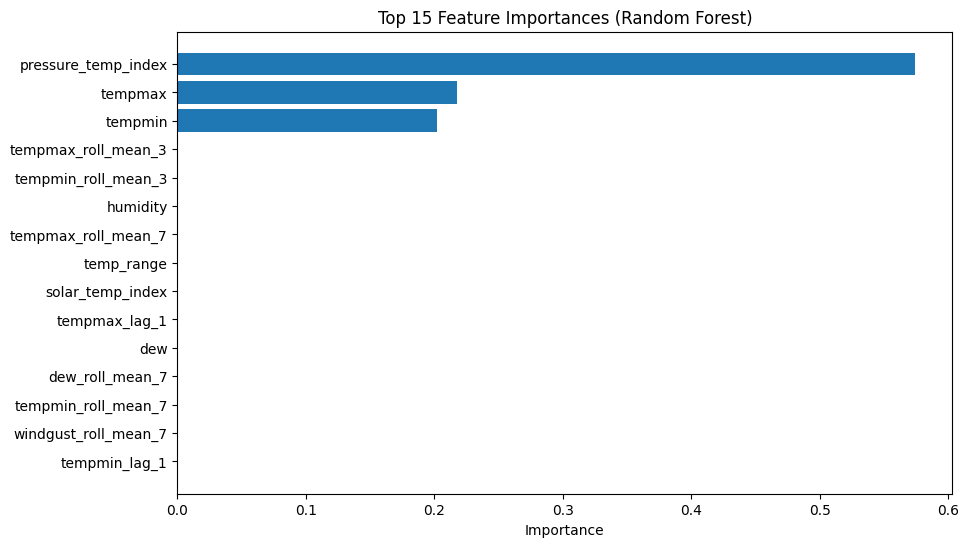

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feat_importance['Feature'][:15], feat_importance['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()


In [66]:
# 3. Evaluate on validation
val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", val_metrics)

# 4. Evaluate on test
test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", test_metrics)

# 5. Save model 
model_path = r'models/RF_model.pkl' 
joblib.dump(model1, model_path)
print(f"RandomForest model saved to {model_path}")

Validation metrics: {'RMSE': np.float64(0.42731243226162613), 'R2': 0.9931343642249196, 'MAPE': np.float64(1.3931957017289864)}
Test metrics: {'RMSE': np.float64(0.44147985901365555), 'R2': 0.9909945674557555, 'MAPE': np.float64(1.3620791071794232)}
RandomForest model saved to models/RF_model.pkl


In [67]:
def object(trial):
   n_estimators = trial.suggest_int('n_estimator', 100, 1000)
   min_samples_split=2
   min_samples_leaf=1
   min_impurity_decrease=0
   max_depth= trial.suggest_int('n_estimator', 10, 50)
   max_features= None
   bootstrap= True
   oob_score= False 
   max_leaf_nodes= None, max_samples= None

   model = RandomForestRegressor(n_estimators = n_estimators, min_samples_split= min_samples_split, min_samples_leaf= min_samples_leaf, min_impurity_decrease= min_impurity_decrease, 
                               max_depth= max_depth, max_features= max_features, bootstrap= bootstrap, oob_score= oob_score, 
                               max_leaf_nodes= max_leaf_nodes, max_samples= max_samples)
   
   score = cross_val_score(model, X_extract_time, y_train, cv)

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (3208592587.py, line 10)

### Extra Tree

In [ ]:
model2 = ExtraTreesClassifier(
    n_estimators=100,    # số cây
    max_features='sqrt', # số feature được xem khi split
    random_state=42
)

### Gradient Boosting (tại model này chưa học, tìm hiểu đã rồi rảnh thì làm random 1 trong 3 đứa :))))